In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chatgpt-reviews-daily-updated/chatgpt_reviews.csv


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishkumarak/chatgpt-reviews-daily-updated")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chatgpt-reviews-daily-updated


In [3]:
import pandas as pd
Chat_Gpt_review=pd.read_csv("/kaggle/input/chatgpt-reviews-daily-updated/chatgpt_reviews.csv")
Chat_Gpt_review.head()

reviewId         userName  \
0  e4f97a57-488d-40ca-8acc-f2e4cf8db9f3         Mut Udom   
1  cc2887ce-e869-4a16-af91-831952c76137    Sampada Khare   
2  b26fe610-1f14-4fa0-a00b-7946fe6ba0f8    Mansir Haruna   
3  61edef34-a1ea-4ea9-9050-cd3c91e51da1  Shalom Mekonnen   
4  793cab76-72a6-4b47-aa26-559d3c746d66    Sheikh SHAMIM   

                                             content  score  thumbsUpCount  \
0                                    កម្មវិធីល្អណាស់      5              0   
1  i like it so much but please make it free so t...      5              0   
2  Discover the power of this incredible AI searc...      5              0   
3                                    this is amazing      3              0   
4                                                গুড      5              0   

  reviewCreatedVersion                   at  appVersion  
0           1.2024.282  2024-10-27 14:04:51  1.2024.282  
1           1.2024.268  2024-10-27 14:04:48  1.2024.268  
2           1.2024.289  2024-10-27 14:04:26  1.2024.289  
3           1.2024.268  2024-10-27 14:03:41  1.2024.268  
4           1.2024.289  2024-10-27 14:02:26  1.2024.289

**Let's Check if there is any Missing value is present or not**

In [4]:
Null_percent=Chat_Gpt_review.isnull().sum()/len(Chat_Gpt_review)
Null_percent

reviewId                0.000000
userName                0.000008
content                 0.000035
score                   0.000000
thumbsUpCount           0.000000
reviewCreatedVersion    0.089161
at                      0.000000
appVersion              0.089161
dtype: float64

**Data PreProcessing**

In [5]:
A=Chat_Gpt_review[(Chat_Gpt_review['score'] == 1)  | (Chat_Gpt_review['score'] == 2 ) | (Chat_Gpt_review['score'] == 3 )]
print(f'Poor {A.shape[0]}')
B=Chat_Gpt_review[(Chat_Gpt_review['score'] == 4)]
print(f'Medium {B.shape[0]}')
C=Chat_Gpt_review[(Chat_Gpt_review['score'] == 5)]
print(f'Good {C.shape[0]}')
Chat_Gpt_review['score'].value_counts()

Poor 30917
Medium 29325
Good 197246


score
5    197246
4     29325
1     15843
3     10595
2      4479
Name: count, dtype: int64

**Define a Function to clean the content column**

In [6]:
!pip install emoji==2.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 3.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234912 sha256=337c875a2739d12808d2643d284ea4c4eaeb1445851b51a90ae3524a3a0588d4
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.13.2
    Uninstalling emoji-2.13.2:
      Successfully uninstalled emoji-2.13.2


In [6]:
Chat_Gpt_review['content']

0                                           កម្មវិធីល្អណាស់
1         i like it so much but please make it free so t...
2         Discover the power of this incredible AI searc...
3                                           this is amazing
4                                                       গুড
                                ...                        
257483                                          Update 2023
257484                                            its grear
257485                                        Funtastic App
257486                                               hi all
257487                                   expert application
Name: content, Length: 257488, dtype: object

In [7]:
Chat_Gpt_review['content'].dropna()

0                                           កម្មវិធីល្អណាស់
1         i like it so much but please make it free so t...
2         Discover the power of this incredible AI searc...
3                                           this is amazing
4                                                       গুড
                                ...                        
257483                                          Update 2023
257484                                            its grear
257485                                        Funtastic App
257486                                               hi all
257487                                   expert application
Name: content, Length: 257479, dtype: object

In [8]:
import re
import string
import emoji
from bs4 import BeautifulSoup
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Emoji demojize function that converts emojis to their descriptive names with custom delimiters.
def replace_emoji_with_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))

def clean_text(text):
    """
    Function to clean a given text string by applying a series of transformations.
    - keep_punctuation: Optional flag to retain specific punctuation characters.
    """
    if not isinstance(text, str):  # Check if the input is a string
        return text
    
    # Convert text to lowercase
    text = text.lower()

    # Remove HTML tags (if any) with an explicit parser
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Replace emojis with text using demojize
    text = replace_emoji_with_text(text)


    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces and newline characters
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    return text

if __name__ == "__main__":

    # Apply the clean_text function to each row in the 'content' column
    # Set keep_punctuation to True or False based on your needs
    Chat_Gpt_review['content'] = Chat_Gpt_review['content'].apply(lambda x: clean_text(x))

    # Show the cleaned content
    print(Chat_Gpt_review['content'])


/tmp/ipykernel_30/1940490838.py:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


0                                           កម្មវិធីល្អណាស់
1         i like it so much but please make it free so t...
2         discover the power of this incredible ai searc...
3                                           this is amazing
4                                                       গুড
                                ...                        
257483                                               update
257484                                            its grear
257485                                        funtastic app
257486                                               hi all
257487                                   expert application
Name: content, Length: 257488, dtype: object


**I am able to see there is some miss spelled words in it so what I can do is I will do a spell correction**

In [10]:
!pip install autocorrect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=4bbb9f89e2704b395287f64ad2c4b3e1b10799a29677e4d8d5fc3d8adcc26153
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [9]:
Chat_Gpt_review['content'].head(10)

0                                      កម្មវិធីល្អណាស់
1    i like it so much but please make it free so t...
2    discover the power of this incredible ai searc...
3                                      this is amazing
4                                                  গুড
5                     clappinghandsmediumlightskintone
6                                     very nice ai app
7                                 the app is so niceee
8                                          found error
9    i am a student of the ba degree and finding tr...
Name: content, dtype: object

**Total Words present before Removal of stop words**

In [10]:
from collections import Counter

results = Counter()
Chat_Gpt_review['content'].astype(str).str.lower().str.split().apply(results.update)
print(len(results.keys()))

58498


**General Wordcloud Count for knowing most frequent words**

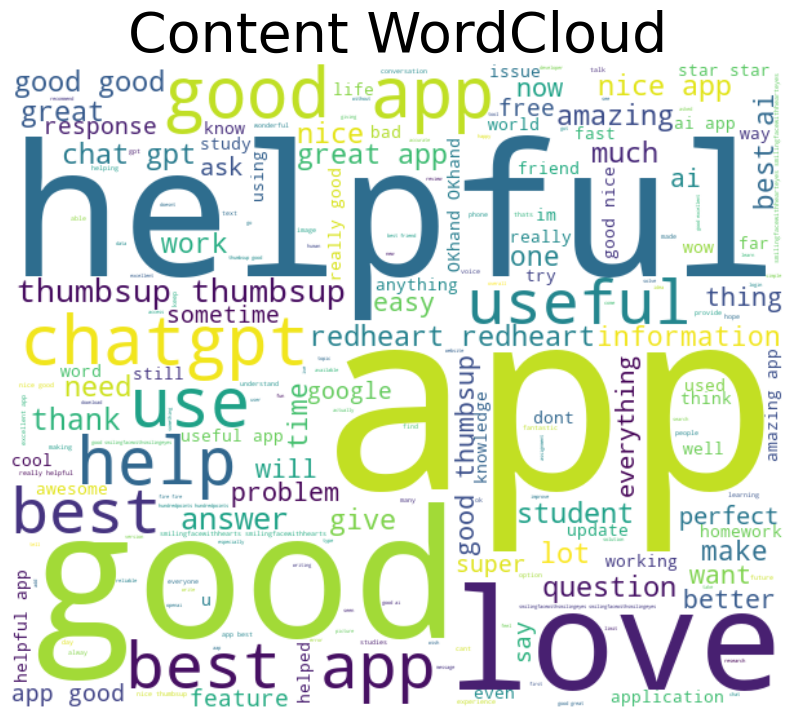

In [11]:
import matplotlib.pyplot as plt  # Correct import
from wordcloud import WordCloud   # Import the WordCloud class

# Set the figure size
plt.figure(figsize=(10, 10))

# Generate the word cloud using the 'content' column of the dataframe
wordcloud1 = WordCloud(background_color='white', 
                       width=600, 
                       height=500).generate(" ".join(Chat_Gpt_review['content'].astype(str)))

# Display the word cloud
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')  # Remove axis labels
plt.title('Content WordCloud', fontsize=40)  # Set the title

# Show the plot
plt.show()


**Now let's see score wise word cloud for Better understanding of the data**

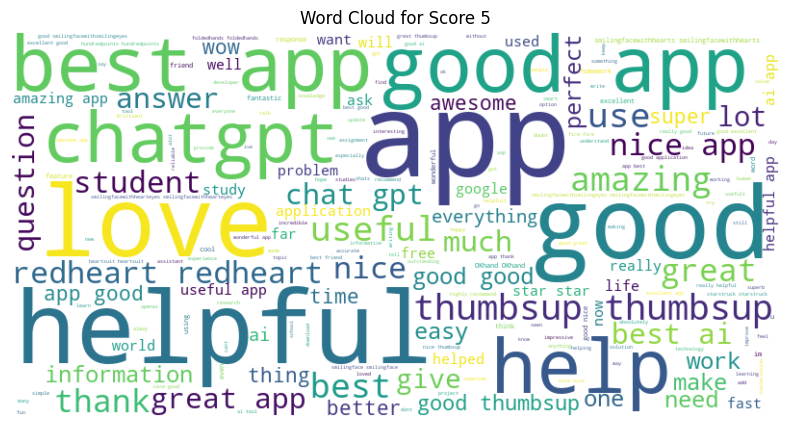

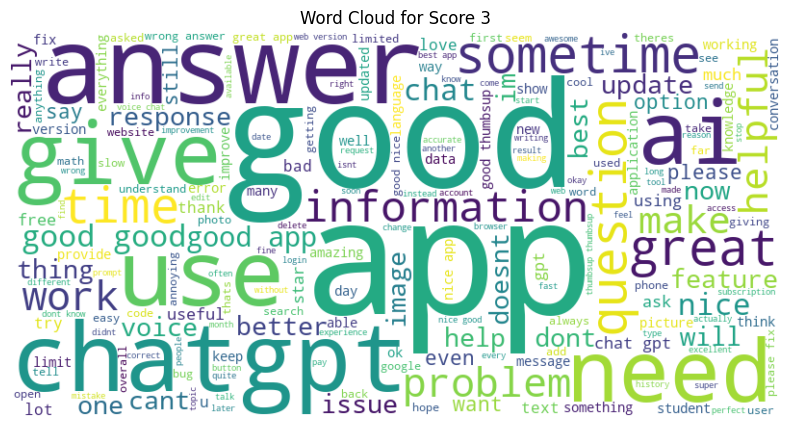

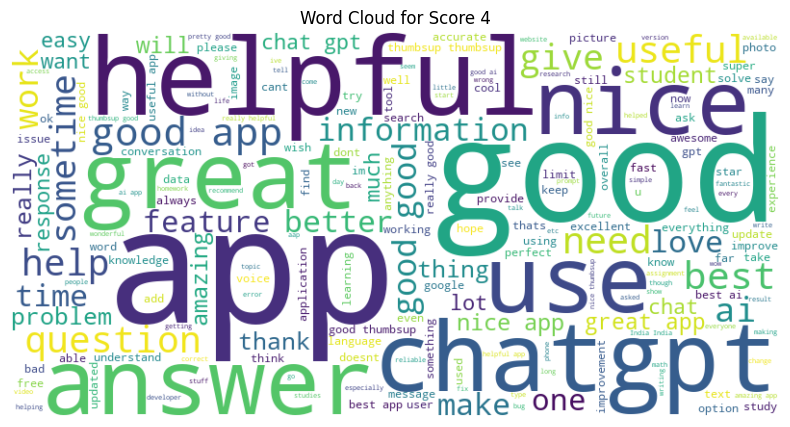

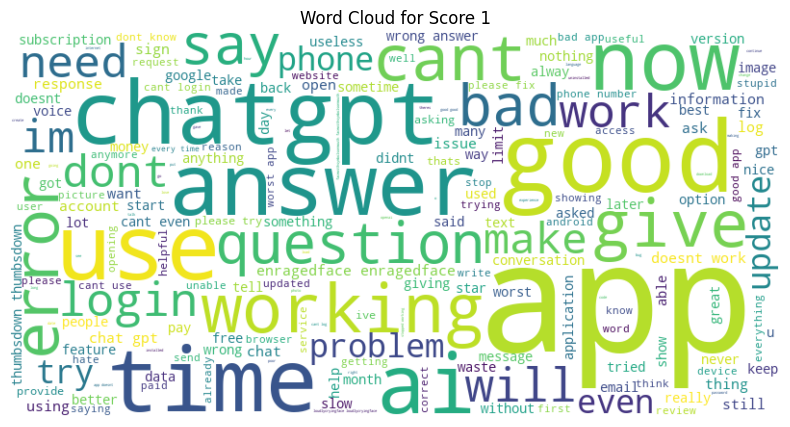

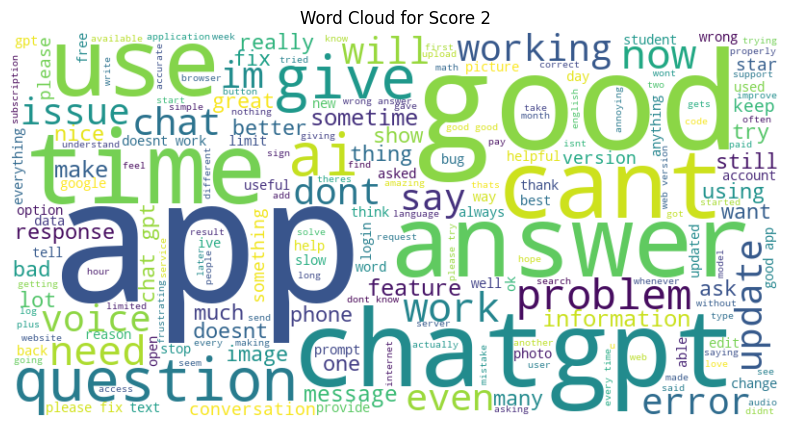

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate a word cloud for a given text
def generate_wordcloud(text, rating):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Score {rating}")
    plt.show()

# Loop through each unique score value
for score in Chat_Gpt_review['score'].unique():
    # Filter the reviews for the current score
    reviews_for_rating = Chat_Gpt_review[Chat_Gpt_review['score'] == score]['content']

    # Combine all reviews for this score into a single string
    all_score_text = ' '.join(reviews_for_rating.astype(str))  # Ensure reviews are strings

    # Generate the word cloud for this score
    generate_wordcloud(all_score_text, score)  # Pass 'score' as the 'rating' argument


**Let drop the Stop Words**

In [13]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')

stop = set(stopwords.words('english'))

# Removing stopwords
Chat_Gpt_review['content'] = Chat_Gpt_review['content'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
Chat_Gpt_review['content'].head(10)

0                                      កម្មវិធីល្អណាស់
1    like much please make free every south asian a...
2    discover power incredible ai search engine you...
3                                              amazing
4                                                  গুড
5                     clappinghandsmediumlightskintone
6                                          nice ai app
7                                           app niceee
8                                          found error
9    student ba degree finding trouble using happy ...
Name: content, dtype: object

**Now Lets Check the word cloud and the unique word count after Removing the Stop words**

In [15]:
from collections import Counter

results = Counter()
Chat_Gpt_review['content'].astype(str).str.lower().str.split().apply(results.update)
print(len(results.keys()))

58358


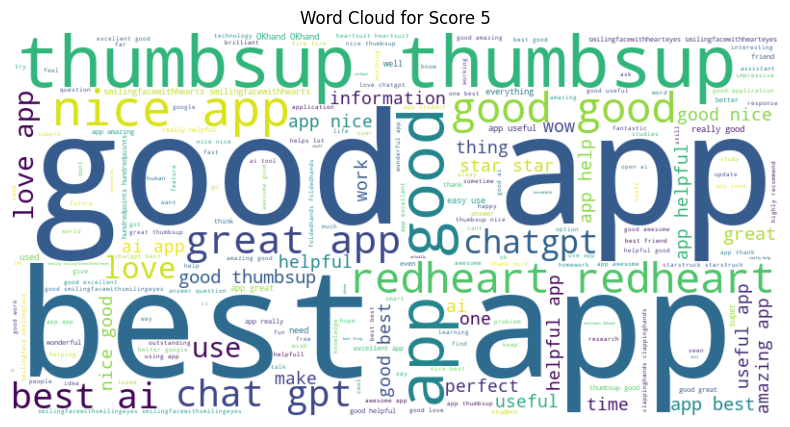

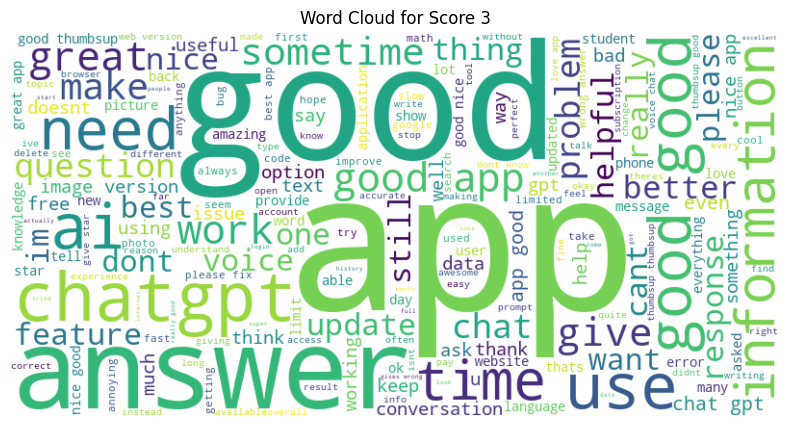

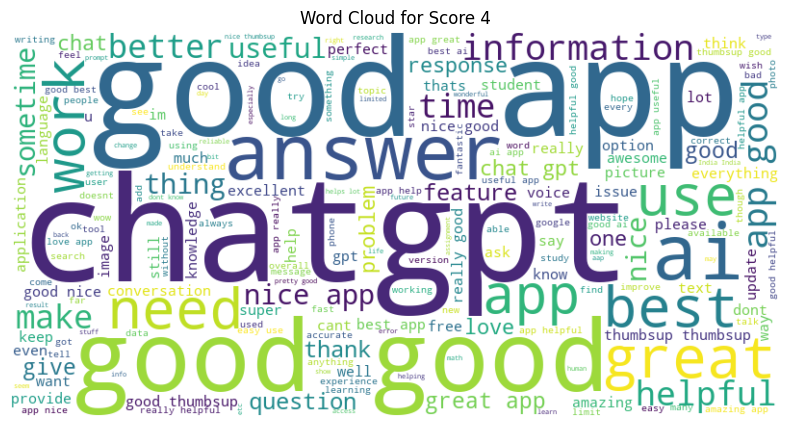

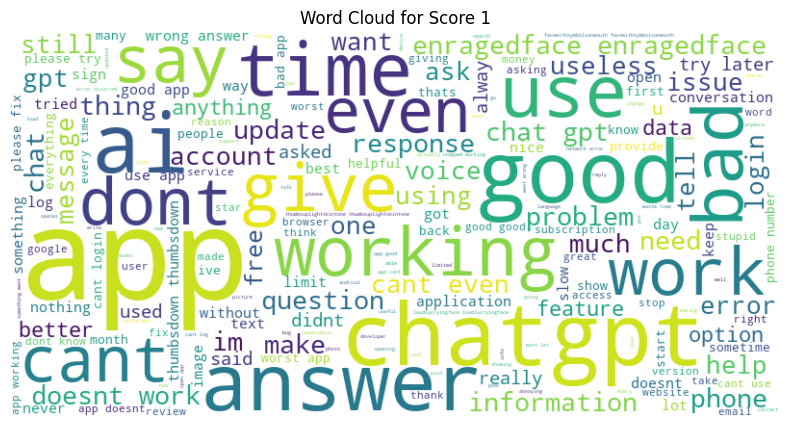

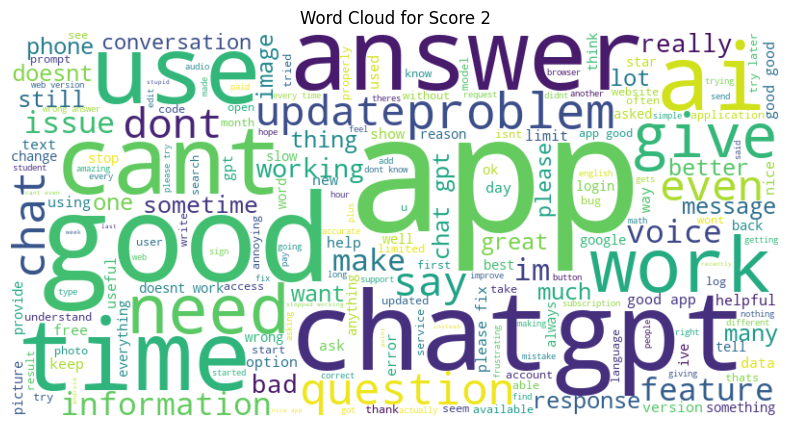

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate a word cloud for a given text
def generate_wordcloud(text, rating):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Score {rating}")
    plt.show()

# Loop through each unique score value
for score in Chat_Gpt_review['score'].unique():
    # Filter the reviews for the current score
    reviews_for_rating = Chat_Gpt_review[Chat_Gpt_review['score'] == score]['content']

    # Combine all reviews for this score into a single string
    all_score_text = ' '.join(reviews_for_rating.astype(str))  # Ensure reviews are strings

    # Generate the word cloud for this score
    generate_wordcloud(all_score_text, score)  # Pass 'score' as the 'rating' argument


**Now check the most frequent words and word Pair using the Bigram,unigram and Trigram**

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [18]:
def get_top_n_words(corpus, n = None):
    """
    A function that returns the top 'n' unigrams used in the corpus
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus) 
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] 
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return freq_sorted[:n]

In [19]:
def get_top_n_bigram(corpus, n = None):
    """
    A function that returns the top 'n' bigrams used in the corpus
    """
    vec = CountVectorizer(ngram_range = (2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_sorted[:n]

In [20]:
def get_top_n_trigram(corpus, n = None):
    """
    A function that returns the top 'n' bigrams used in the corpus
    """
    vec = CountVectorizer(ngram_range = (3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freq_sorted = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_sorted[:n]

**Lets Plot and Check the Unigram,Bigram and Trigram Visually**

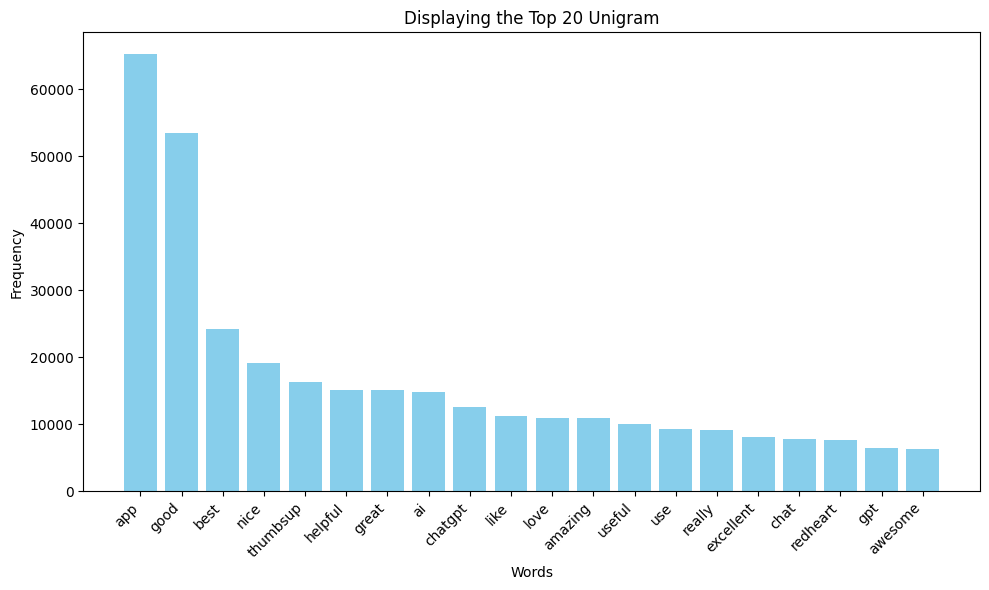

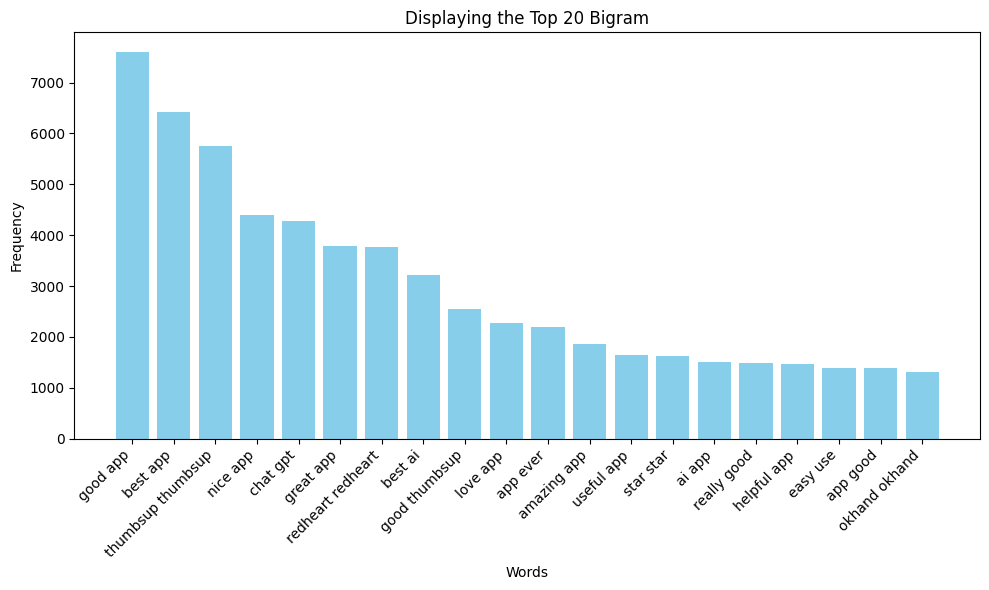

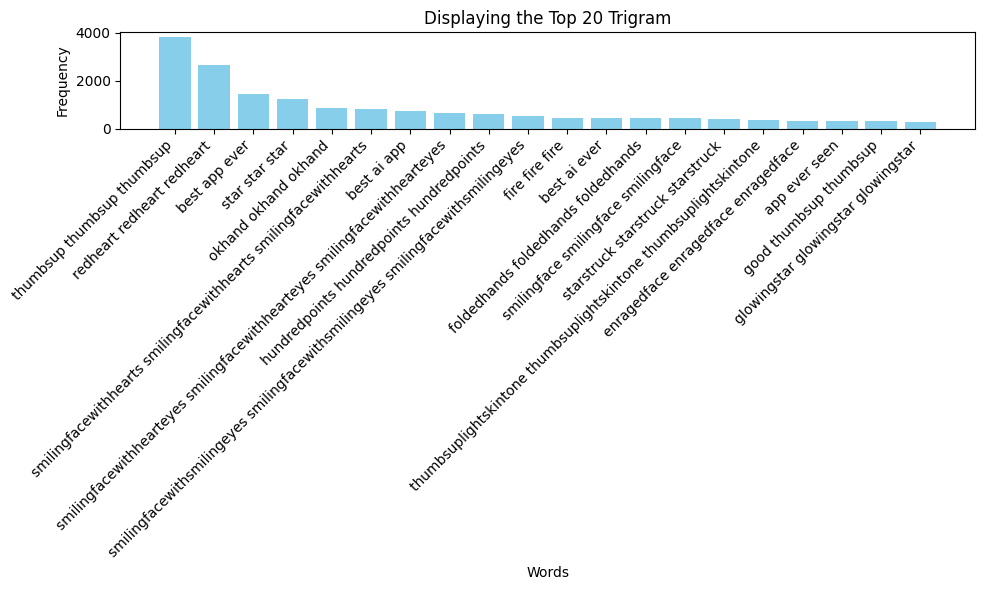

In [21]:
import matplotlib.pyplot as plt


for i,j in zip([get_top_n_words,get_top_n_bigram,get_top_n_trigram],['Unigram','Bigram','Trigram']):
    top_20 = i(Chat_Gpt_review['content'], 20)
    
    words = [i[0] for i in top_20]
    counts = [i[1] for i in top_20]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Displaying the Top 20 {j}')
    plt.tight_layout()  # Adjust layout to fit x labels
    plt.show()





**Now Lets do a Lemmatization**

In [22]:
!python -m spacy download en_core_web_sm
!python -m spacy pretrain <PATH_TO_DATA> --use-gpu 0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/bin/bash: line 1: PATH_TO_DATA: No such file or directory


In [23]:
import spacy
from tqdm import tqdm  # For progress tracking

# Load the SpaCy model with GPU support
spacy.require_gpu()
nlp = spacy.load('en_core_web_sm')

# Function to lemmatize using the pipe method for batch processing
def lemmatize_texts(texts):
    lemmatized_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=1000)):
        clean_text = ' '.join([token.lemma_ for token in doc])
        lemmatized_texts.append(clean_text)
    return lemmatized_texts

# Apply the optimized lemmatization
Chat_Gpt_review['content'] = lemmatize_texts(Chat_Gpt_review['content'].values)

# Check the first 50 lemmatized rows
for i in range(50):
    print(Chat_Gpt_review['content'][i])


257488it [02:56, 1459.07it/s]

កម្មវិធីល្អណាស់
like much please make free every south asian access love work
discover power incredible ai search engine you re use yet you re truly miss something revolutionary
amazing
গুড
clappinghandsmediumlightskintone
nice ai app
app niceee
find error
student ba degree find trouble use happy let able complete desire fullfill daily need developer chat gpt ordinary user great helpful application feel frustration inability provide knowledge past conversation fix perfection great application appreciate valuable product thank understand
nice
perfect
good
thumbsuplightskintone
great
good
super
love
one good
good app
good even help homework great tool
speak several language like amharicafaan oromo
안녕하세요 이 앱을 만든 분들께 감사드리고 싶습니다 정말 최고예요 partyingface starstruck
really convenient come practice english use
like ai system winkingface faceblowingakiss smilingfacewithheart
amazing do not audio file access
ok
help solve problem grinningfacewithsmilingeye
good ai helpful
akdm mst roundpushpin hundr

**Now Let Do a POS Tag and see which tags presents the most**

In [26]:
!pip install nltk

In [24]:
import nltk
nltk.download('averaged_perceptron_tagger')  # POS tagger


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [25]:
from nltk import pos_tag
# Apply POS tagging to each row in 'excerpt_clean'
Chat_Gpt_review['pos_tags'] = Chat_Gpt_review['content'].astype(str).str.split().map(pos_tag)

# Display the resulting DataFrame with POS tags
print(Chat_Gpt_review[['content', 'pos_tags']].head(15))


                                              content  \
0                                     កម្មវិធីល្អណាស់   
1   like much please make free every south asian a...   
2   discover power incredible ai search engine you...   
3                                             amazing   
4                                                 গুড   
5                    clappinghandsmediumlightskintone   
6                                         nice ai app   
7                                          app niceee   
8                                          find error   
9   student ba degree find trouble use happy let a...   
10                                               nice   
11                                            perfect   
12                                               good   
13                              thumbsuplightskintone   
14                                              great   

                                             pos_tags  
0                             [

In [26]:
def count_tags(pos_tags):
    tag_count = {}
    for word,tag in pos_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return tag_count

Chat_Gpt_review['tag_counts'] = Chat_Gpt_review['pos_tags'].map(count_tags)

In [27]:
Chat_Gpt_review.tag_counts.head()

0                                            {'NN': 1}
1       {'IN': 1, 'JJ': 4, 'NN': 4, 'VBP': 1, 'DT': 1}
2    {'NN': 5, 'JJ': 4, 'PRP': 2, 'VBP': 2, 'VB': 1...
3                                           {'VBG': 1}
4                                            {'NN': 1}
Name: tag_counts, dtype: object

**Now Lets do a Named Entity recognation**

In [31]:
import spacy
import pandas as pd
from tqdm import tqdm

# Ensure spaCy uses the GPU
spacy.require_gpu()


# Enable tqdm for progress tracking
tqdm.pandas(desc="Extracting Entities")

# Optimized function to extract entities in batches
def extract_entities_in_batches(texts):
    entities_list = []
    for doc in nlp.pipe(texts, batch_size=32):  # Process in batches of 32
        entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract entities
        entities_list.append(entities)
    return entities_list

# Apply the optimized NER extraction with progress tracking
Chat_Gpt_review['entities'] = extract_entities_in_batches(
    tqdm(Chat_Gpt_review['content'], desc="Processing NER")
)

# Display the first 10 rows with extracted entities
print(Chat_Gpt_review[['content', 'entities']].head(10))


Processing NER: 100%|██████████| 253911/253911 [08:43<00:00, 484.92it/s]


                           content entities
0                             good       []
1                   really helfull       []
2                                        []
3           good app useful OKhand       []
4                          helpful       []
5                             good       []
6  good u limited use send picture       []
7                             good       []
8                 good always free       []
9                         well app       []


In [32]:
filtered_df=Chat_Gpt_review[Chat_Gpt_review['entities'].map(len)>1]
print(filtered_df.shape)
filtered_df.entities.head()

(5933, 11)


183     [(राम्रो लाग्यो, ORG), (सुधार्ने भनेर, PRODUCT)]
259    [(hai, GPE), (jo har tarah ki, PERSON), (madad...
286    [(achcha laga, PERSON), (ko chhu, PERSON), (ga...
380    [(one, CARDINAL), (google, ORG), (one, CARDINAL)]
431    [(mudah digunakan dan memberikan, PERSON), (ja...
Name: entities, dtype: object

**Since it is a review Content there is not much Entity is present**

**Data Preperation for Model Training**

In [28]:
#Let combine the scores to tackle the Class Imbalance
print(f'Before Combining the classes {Chat_Gpt_review.score.value_counts()}')
Chat_Gpt_review.loc[(Chat_Gpt_review['score'] == 1) | (Chat_Gpt_review['score'] == 2) | (Chat_Gpt_review['score'] == 3), 'score'] = 0
Chat_Gpt_review.loc[(Chat_Gpt_review['score'] == 4), 'score'] = 1
Chat_Gpt_review.loc[Chat_Gpt_review['score'] == 5, 'score'] = 2
print(f'After Combining the classes {Chat_Gpt_review.score.value_counts()}')

Before Combining the classes score
5    197246
4     29325
1     15843
3     10595
2      4479
Name: count, dtype: int64
After Combining the classes score
2    197246
0     30917
1     29325
Name: count, dtype: int64


**Now Atleast the 1 and 2 class are balanced let's check the Models performance without doing any balancing technique**

**Now Lets split the test and Traing data**

In [41]:
from sklearn.model_selection import train_test_split

X=Chat_Gpt_review['content']
y=Chat_Gpt_review['score']


x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42,stratify=y)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

193116 193116
64372 64372


In [35]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier  # XGBoost supports GPU
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.pipeline import make_pipeline
# from tqdm import tqdm  # For progress display
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming Chat_Gpt_review is a dataframe with columns 'content' (text) and 'score' (target)
# X = Chat_Gpt_review['content']  # Text data
# y = Chat_Gpt_review['score']    # Target labels

# # Step 1: Split the data into training and test sets (80% training, 20% testing)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# # List of models to evaluate
# models = [
#     ("Logistic Regression", LogisticRegression(max_iter=1000, multi_class='ovr', class_weight='balanced')),
#     ("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5)),
#     ("Decision Tree", DecisionTreeClassifier(random_state=42)),
#     ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
#     ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist'))  # GPU optimization for XGBoost
# ]

# # Step 2: Vectorize the text data using CountVectorizer
# vectorizer = CountVectorizer(ngram_range=(1, 1))  # Use bigrams
# X_train_vect = vectorizer.fit_transform(X_train)
# X_test_vect = vectorizer.transform(X_test)

# # Step 3: Perform training and evaluation on each model
# for name, model in tqdm(models, desc="Training and Evaluating Models"):
#     print(f"\nEvaluating: {name}")
    
#     # Perform cross-validation on the training set using StratifiedKFold
#     skf = StratifiedKFold(n_splits=5)
    
#     # Cross-validation score on the training data
#     cv_scores = cross_val_score(model, X_train_vect, y_train, scoring='accuracy', cv=skf)
    
#     # Print mean cross-validation accuracy
#     print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")
    
#     # Step 4: Fit the model on the full training set and evaluate on the test set
#     model.fit(X_train_vect, y_train)
#     y_pred_test = model.predict(X_test_vect)
    
#     # Step 5: Evaluate the model on the test set using accuracy
#     test_accuracy = accuracy_score(y_test, y_pred_test)
#     print(f"Test Set Accuracy: {test_accuracy:.4f}")
    
#     # Step 6: Display classification report
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred_test))
    
#     # Step 7: Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred_test)
    
#     # Plotting the Confusion Matrix
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
#     plt.title(f"Confusion Matrix - {name}")
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted')
#     plt.show()

**Since there is a class imbalance First Lets Fix the class imbalance and then train the model**

**First Lets Do a Undersampling and test the Models performance**

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

# Split the data
X = Chat_Gpt_review['content']
y = Chat_Gpt_review['score']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Vectorize text data using CountVectorizer (unigram)
vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_vec, y_train)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    #"Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',tree_method='gpu_hist')
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_vec)
    print(f"{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

Training Logistic Regression...
Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.62      0.52      7636
           1       0.16      0.44      0.23      7232
           2       0.88      0.60      0.72     48610

    accuracy                           0.59     63478
   macro avg       0.50      0.55      0.49     63478
weighted avg       0.75      0.59      0.64     63478

Training K-Nearest Neighbors...
K-Nearest Neighbors Classification Report:

              precision    recall  f1-score   support

           0       0.28      0.63      0.39      7636
           1       0.13      0.41      0.20      7232
           2       0.87      0.43      0.57     48610

    accuracy                           0.45     63478
   macro avg       0.43      0.49      0.39     63478
weighted avg       0.71      0.45      0.51     63478

Training Decision Tree...
Decision Tree Classification Report:

              precisio

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:40:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.20      0.29      7636
           1       0.43      0.02      0.03      7232
           2       0.79      0.98      0.87     48610

    accuracy                           0.77     63478
   macro avg       0.57      0.40      0.40     63478
weighted avg       0.71      0.77      0.71     63478



/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:40:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:40:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


**Lets Do a Oversampling and check the models performance**

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
# Split the data
X = Chat_Gpt_review['content']
y = Chat_Gpt_review['score']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Vectorize text data using CountVectorizer (unigram)
vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Perform undersampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_vec, y_train)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    #"Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',tree_method='gpu_hist')
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_vec)
    print(f"{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))


Training Logistic Regression...
Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.60      0.53      7636
           1       0.17      0.40      0.23      7232
           2       0.88      0.67      0.76     48610

    accuracy                           0.63     63478
   macro avg       0.51      0.55      0.51     63478
weighted avg       0.75      0.63      0.67     63478

Training K-Nearest Neighbors...
K-Nearest Neighbors Classification Report:

              precision    recall  f1-score   support

           0       0.30      0.56      0.39      7636
           1       0.13      0.45      0.20      7232
           2       0.86      0.44      0.58     48610

    accuracy                           0.45     63478
   macro avg       0.43      0.48      0.39     63478
weighted avg       0.71      0.45      0.51     63478

Training Decision Tree...
Decision Tree Classification Report:

              precisio

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:02:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.19      0.66      0.29      7636
           1       0.14      0.40      0.21      7232
           2       0.85      0.28      0.42     48610

    accuracy                           0.34     63478
   macro avg       0.39      0.45      0.31     63478
weighted avg       0.69      0.34      0.38     63478



/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:03:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


**Now do a same thing with the TF-IDF and check the models performance**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

# Split the data
X = Chat_Gpt_review['content']
y = Chat_Gpt_review['score']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Vectorize text data using TF-IDF (unigram)
vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigram TF-IDF
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

# Perform undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_vec, y_train)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    #"Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',tree_method='gpu_hist')
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_vec)
    print(f"{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

Training Logistic Regression...
Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.43      0.64      0.51      7636
           1       0.16      0.45      0.23      7232
           2       0.89      0.58      0.70     48610

    accuracy                           0.57     63478
   macro avg       0.49      0.56      0.48     63478
weighted avg       0.75      0.57      0.63     63478

Training K-Nearest Neighbors...


**Now let's check with the oversampling**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

# Split the data
X = Chat_Gpt_review['content']
y = Chat_Gpt_review['score']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Vectorize text data using TF-IDF (unigram)
vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigram TF-IDF
X_train_vec = vectorizer.fit_transform(x_train)
X_test_vec = vectorizer.transform(x_test)

oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_vec, y_train)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr', class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    #"Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',tree_method='gpu_hist')
}

# Train and evaluate models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_vec)
    print(f"{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))

# **Now let's Check with the Neural Network**

**First Let's find the optimal num_words for the tokeninzing**

In [45]:
# Calculate word coverage from the tokenizer's word frequency
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
total_words = 57655  # Example vocab size

texts=Chat_Gpt_review['content'].tolist()

Sample_tokenizer = Tokenizer()
Sample_tokenizer.fit_on_texts(texts)


word_counts = Sample_tokenizer.word_counts
sorted_word_counts = sorted(word_counts.values(), reverse=True)

cumulative_count = np.cumsum(sorted_word_counts)
coverage = cumulative_count / cumulative_count[-1]  # Normalize to get percentages

# Find the minimum number of words needed for 95% coverage
num_words = np.searchsorted(coverage, 0.95)
print(f"Number of words for 95% coverage: {num_words}")

Number of words for 95% coverage: 7673


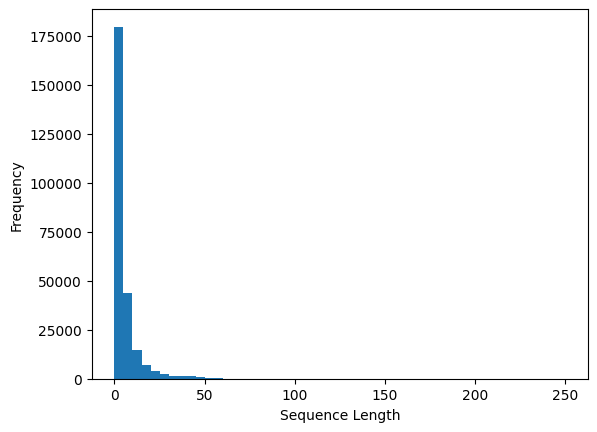

In [47]:
# Tokenize all the text data
all_sequences = Sample_tokenizer.texts_to_sequences(texts)
# Get the length of each sequence
sequence_lengths = [len(seq) for seq in all_sequences]

# Visualize the sequence length distribution
import matplotlib.pyplot as plt
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [48]:
# Determine 95th percentile length
max_length = int(np.percentile(sequence_lengths, 95))
print(f"Max Length for 95% coverage: {max_length}")


Max Length for 95% coverage: 19


In [49]:
# Calculate embedding dimension based on vocab size
vocab_size = 57655  
embedding_dim = int(np.cbrt(vocab_size))
print(f"Recommended Embedding Dimension: {embedding_dim}")

Recommended Embedding Dimension: 38


In [50]:
vocab_size = min(10000, len(Sample_tokenizer.word_index) + 1)  # Add 1 for OOV token
print(f"Vocab Size: {vocab_size}")


Vocab Size: 10000


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1509/1509 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7680 - loss: 0.7142 - val_accuracy: 0.7660 - val_loss: 0.6689
Epoch 2/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7659 - loss: 0.6743 - val_accuracy: 0.7660 - val_loss: 0.6741
Epoch 3/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7680 - loss: 0.6707 - val_accuracy: 0.7660 - val_loss: 0.6692
Epoch 4/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7639 - loss: 0.6652 - val_accuracy: 0.7660 - val_loss: 0.6496
Epoch 5/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.7689 - loss: 0.6449 - val_accuracy: 0.8108 - val_loss: 0.5788
Epoch 6/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8134 - loss: 0.5706 - val_accuracy: 0.8146 - val_loss: 0.5593
Epoch 7/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8186 - loss: 0.5471 - val_accuracy: 0.8152 - val_loss: 0.5530
Epoch 8/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8234 - loss: 0.5319 - va

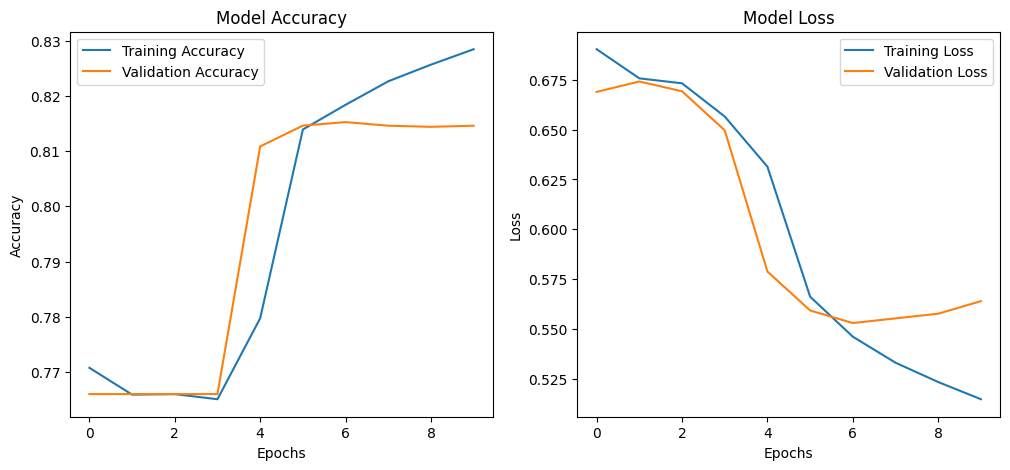

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

# Tokenization
num_words = 10000  
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

# Convert text to sequences and pad them
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to uniform length
max_length = 50  # 95th percentile length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Define the model
embedding_dim = 40  # Based on 4th root rule
vocab_size = min(num_words, len(tokenizer.word_index) + 1) 

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')  # For multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and capture training history
history = model.fit(
    X_train_padded, y_train, 
    validation_data=(X_test_padded, y_test),
    epochs=10, batch_size=128
)

# Plotting accuracy and loss curves
def plot_learning_curves(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)  # Subplot 1: Accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)  # Subplot 2: Loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the plotting function
plot_learning_curves(history)

In [58]:
def preprocess_review(review, tokenizer, max_length=50):
    """
    Preprocess the input review: Tokenize and pad it to match the input size of the model.
    """
    # Tokenize the review
    review_seq = tokenizer.texts_to_sequences([review])
    
    # Pad the sequence to ensure uniform input length
    review_padded = pad_sequences(review_seq, maxlen=max_length, padding='post', truncating='post')
    
    return review_padded

def predict_score(review, model, tokenizer):
    """
    Predict the score based on the given review using the trained model.
    """
    # Preprocess the review
    review_padded = preprocess_review(review, tokenizer)
    
    # Predict the score
    prediction = model.predict(review_padded)
    
    # Get the predicted class (score) with the highest probability
    predicted_score = np.argmax(prediction, axis=1)[0]
    
    return predicted_score

# Example usage
new_review = "Chatgpt Very good"
predicted_score = predict_score(new_review, model, tokenizer)

print(f"Predicted Score: {predicted_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Score: 2


**Till now the Sentiment analysis part is over Now Let Explore someother thing to understand more functionality in the NLP**

In [4]:
Sample_Text="""In particular, the study looks at the high-energy jet of particles being blasted across space by the supermassive black hole at the center of the galaxy Centaurus A.

Jets are visible to different types of telescopes, including those that detect radio waves and others that collect X-rays. Since Chandra's 1999 launch, many astronomers have been particularly interested in the unexpectedly bright X-ray signals from jets.

Still, it appeared that X-ray observations were essentially capturing the same features as their more established radio counterparts, which isn't the most exciting outcome.

Jets are massive cosmic structures -- some are larger than their host galaxies -- that still harbor many mysteries. If a jet looks the same to different instruments, that doesn't do any favors for the folks working to unravel these astrophysical puzzles.

"A key to understanding what's going on in the jet could be understanding how different wavelength bands trace different parts of the environment," said lead author David Bogensberger, a postdoctoral fellow at U-M. "Now we have that possibility."

The new study is the latest entry in a small but growing body of research that's digging deeper into data to spot subtle, meaningful differences between radio and X-ray observations.

"The jet in X-rays is different from the jet in radio waves," Bogensberger said. "The X-ray data traces a unique picture that you can't see in any other wavelength."

Bogensberger and an international team of colleagues published their findings in The Astrophysical Journal.

In its study, the team looked at Chandra's observations of Centaurus A from 2000 to 2022. Or, more accurately, Bogensberger developed a computer algorithm to do that. The algorithm tracked bright, lumpy features in the jet, which are called knots. By following knots that moved during the observation period, the team could then measure their speed.

The speed of one knot was particularly remarkable. In fact, it appeared to be moving faster than the speed of light because of how it moves relative to Chandra's vantage point near Earth. The distance between the knot and Chandra shrinks almost as fast as light can travel.

The team determined the knot's actual speed was at least 94% the speed of light. A knot in a similar location had previously had its speed measured using radio observations. That result clocked the knot with a significantly slower speed, about 80% the speed of light.

"What this means is that radio and X-ray jet knots move differently," Bogensberger said.

And that wasn't the only thing that stood out from the data.

For example, radio observations of knots suggested the structures closest to the black hole move the fastest. In the new study, however, Bogensberger and his colleagues found the fastest knot in a sort of middle region -- not the farthest from the black hole, but not the nearest to it either.

"There's a lot we still don't really know about how jets work in the X-ray band. This highlights the need for further research," Bogensberger said. "We've shown a new approach to studying jets and I think there's a lot of interesting work to be done."

For his part, Bogensberger will be using the team's approach to examine other jets. The jet in Centaurus A is special because it's the closest jet we know of at about 12 million light years away.

This relative proximity made it a good first option for testing and validating the team's methodology. Features like knots become more challenging to resolve in jets that are farther away.

"But there are other galaxies where this analysis can be done," Bogensberger said. "And that's what I plan to do next."""

**First Let's do A POS Tag and also check how one word is interconnected with other**

In [1]:
import spacy
nlp = spacy.load('en_core_web_lg')
from spacy import displacy

**POS Tagging and How words connected Together**

In [5]:
doc1 = nlp(Sample_Text)
displacy.render(doc1, style="dep")

**Named Entity Recognition**

In [6]:
displacy.render(doc1, style="ent")